Brandon Pover - bnp669
Karthick Ramasubramanian - kr33733
Matthew Tran - mct2345
Shubham Singh - ss96589

In [ ]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt

## Importing CSV Files

In [2]:
bonds_from_wsj = pd.read_csv('bonds_from_wsj.csv')
bonds = pd.read_csv('bonds.csv')
bonds['Y0Price'] = bonds['Price']
bonds.loc[bonds.StartTime > 0, 'Y0Price'] = 0 # marking forward bonds' price $0 for Year 0 price
liabilities = pd.read_csv('liabilities.csv')
bonds

,Bond,Price,Coupon,StartTime,Maturity,Y0Price
0,1,102,5.0,0,1,102
1,2,100,3.0,1,2,0
2,3,99,3.5,0,2,99
3,4,101,4.0,0,2,101
4,5,98,2.5,0,3,98
5,6,98,4.0,0,4,98
6,7,98,2.0,2,4,0
7,8,104,9.0,0,5,104
8,9,100,6.0,0,5,100
9,10,101,8.0,0,6,101


In [3]:
liabilities

,Year,Liability
0,1,1200000
1,2,1800000
2,3,2000000
3,4,2000000
4,5,1600000
5,6,1500000
6,7,1200000
7,8,1000000


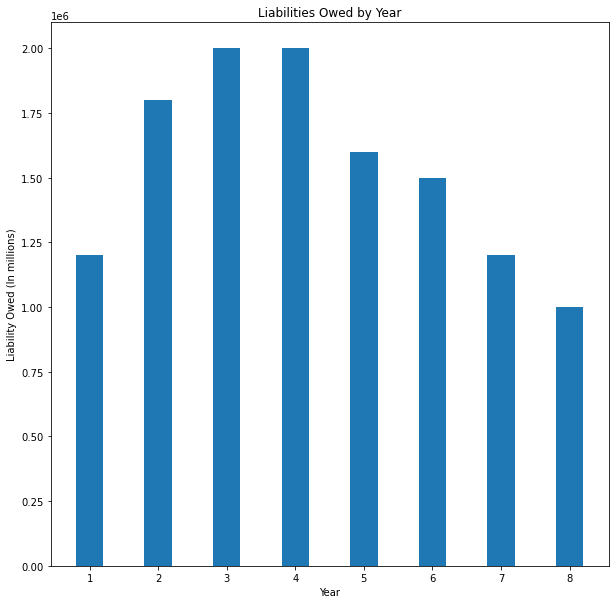

In [4]:
fig = plt.figure(figsize = (10, 10))
 
# creating the bar plot
plt.bar(liabilities['Year'], liabilities['Liability'],
        width = 0.4)
 
plt.xlabel("Year")
plt.ylabel("Liability Owed (In millions)")
plt.title("Liabilities Owed by Year")
plt.show()

## Create Matrix of Constraints

In [5]:
#Create empty matrix: rows = # of bonds, columns = # of years
payouts = np.zeros((len(bonds),len(liabilities)))

#Input the amount recieved at Maturtity (Face Value + Coupon)
for i in range(len(bonds)):
    if int(bonds.iloc[i]['StartTime']) != 0:
        payouts[i, int(bonds.iloc[i]['StartTime']-1)] =  -bonds.iloc[i]['Price']
        payouts[i, int(bonds.iloc[i]['Maturity']-1)] =  bonds.iloc[i]['Price'] + bonds.iloc[i]['Coupon']
    else:
        payouts[i, int(bonds.iloc[i]['Maturity']-1)] =  bonds.iloc[i]['Price'] + bonds.iloc[i]['Coupon']
    #Input coupon amounts for relevent years
    for j in range(int(bonds.iloc[i]['StartTime']), int(bonds.iloc[i]['Maturity']-1)):
        payouts[i,j] = bonds.iloc[i]['Coupon']

#Transpose matrix
A = payouts.T
pay = pd.DataFrame(A)
pay

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,107.0,-100.0,3.5,4.0,2.5,4.0,0.0,9.0,6.0,8.0,9.0,7.0,0.0
1,0.0,103.0,102.5,105.0,2.5,4.0,-98.0,9.0,6.0,8.0,9.0,7.0,0.0
2,0.0,0.0,0.0,0.0,100.5,4.0,2.0,9.0,6.0,8.0,9.0,7.0,-91.0
3,0.0,0.0,0.0,0.0,0.0,102.0,100.0,9.0,6.0,8.0,9.0,7.0,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.0,106.0,8.0,9.0,7.0,3.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0,9.0,7.0,3.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.0,7.0,3.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,94.0


## Setting Objective and b vector

In [6]:
#Set objective to bond prices
obj = np.array(bonds['Y0Price'])

#Set the amount needed each year
b = np.array(liabilities['Liability'])

#Cashflow matching
sense = np.array(['=']*len(liabilities))

## Solving for Optimal Portfolio

In [7]:
#Model Set UP
model = gp.Model()

modelX = model.addMVar(len(bonds), lb = 0.0 )
modelCon = model.addMConstrs(A, modelX, sense, b)
model.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

model.Params.OutputFlag = 0

model.optimize()

print('The value of the portfolio today is:', round(model.objVal,2))

Academic license - for non-commercial use only - expires 2022-08-21
Using license file C:\Users\Hatricano\gurobi.lic
The value of the portfolio today is: 9473468.04


In [8]:
# Total Bond Purchase
quantity = pd.DataFrame(model.x, index = ['Bond_%i'%(i) for i in range(1,len(bonds)+1)], columns = ['Quantity'] )
quantity

,Quantity
Bond_1,18905.515879
Bond_2,12920.641375
Bond_3,0.000000
Bond_4,0.000000
Bond_5,15620.674098
Bond_6,16019.160682
Bond_7,0.000000
Bond_8,11864.946053
Bond_9,0.000000
Bond_10,12284.543604


## Performing Sensitivity Analysis on Liability Estimates

In [9]:
# Shadow Costs/ Dual Variables (change in optimal value of the objective function per unit increase in the RHS value for the constraint, all other problem data held constant)
[con.Pi for con in modelCon]

[0.9532710280373832,
 0.9255058524634788,
 0.9283886348134114,
 0.850699391556303,
 0.6290196091872993,
 0.6119717786379542,
 0.5217143544841221,
 0.5550099550073301]

In [10]:
# Upper and lower bound where shadow prices are valid
Contraints_bounds = pd.DataFrame(data= np.array([con.SARHSLow for con in modelCon]), columns= ['Lower Bound'], index = ['Year%i'%(i) for i in range(1,len(liabilities)+1)] )
Contraints_bounds['Upper Bound'] = np.array([con.SARHSUp for con in modelCon])
Contraints_bounds['Actual Liabilities'] = np.array(liabilities['Liability'])
Contraints_bounds

,Lower Bound,Upper Bound,Actual Liabilities
Year1,-822890.199052,inf,1200000
Year2,469173.938412,inf,1800000
Year3,430122.253167,4.326098e+07,2000000
Year4,366045.610440,2.884069e+07,2000000
Year5,259261.095958,1.535509e+07,1600000
Year6,160984.747123,1.771844e+07,1500000
Year7,69306.930693,1.704376e+07,1200000
Year8,0.000000,1.731429e+07,1000000


In [11]:
# Range of objective values where optimal corner stays the same
Objective_bounds = pd.DataFrame(data= np.array(modelX.SAObjLow), columns= ['Lower Bound'], index = ['Bond_%i'%(i) for i in range(1,len(bonds)+1)] )
Objective_bounds['Upper Bound'] = np.array(modelX.SAObjUp)
Objective_bounds['Actual Price'] = np.array(bonds['Price'])
Objective_bounds

,Lower Bound,Upper Bound,Actual Price
Bond_1,98.072248,102.008889,102
Bond_2,-3.814567,0.008634,100
Bond_3,98.200798,inf,99
Bond_4,100.991199,inf,101
Bond_5,72.552007,inf,98
Bond_6,-377.102221,101.848314,98
Bond_7,-3.772857,inf,98
Bond_8,-820.001482,116.128026,104
Bond_9,88.623268,inf,100
Bond_10,-724.877431,inf,101


**Liability Estimate Variation**

- The shadow prices show that an increase of \\$1 of liabilities, in their respective years in the data set as well as the order shown here, represent the increase of the price in the year 0 portfolio. The descending nature of the values in the list, shown in this section, roughly show the concept of the time value of money. For example, if the liabilities due in year 8 were to increase by \\$1, the investment required to fullfill that extra dollar would only be \\$0.56 as compared to an increase in year 1 at \\$0.95. Therefore, the later year liabilties are our least sensitive factors and the nearest liabilities are our most sensitive to variations in the estimates. 

- The upper and lower bounds show the range of values that the liabilities could change and our shadow prices are still good estimates of the change in portfolio value in year 0. The ranges are extremely large which allows many different scenarios of liability amounts to be analyzed as a function of year 0 portfolio value. 

- The range of objective values (Year 0 Bond Prices) shows how much each bond's price can vary in year 0 and keep the same minimized portfolio value. The lower bounds that are negative and the upper bounds that are infinity are obviously not realistic or realistically insightful, so they will be ignored. Therefore, you can see that the optimal portfolio value is most sensitive to Bond 1's price. This is not surprising as it is a one year bond and our liabilities are most senstitive to changes in year 1. 

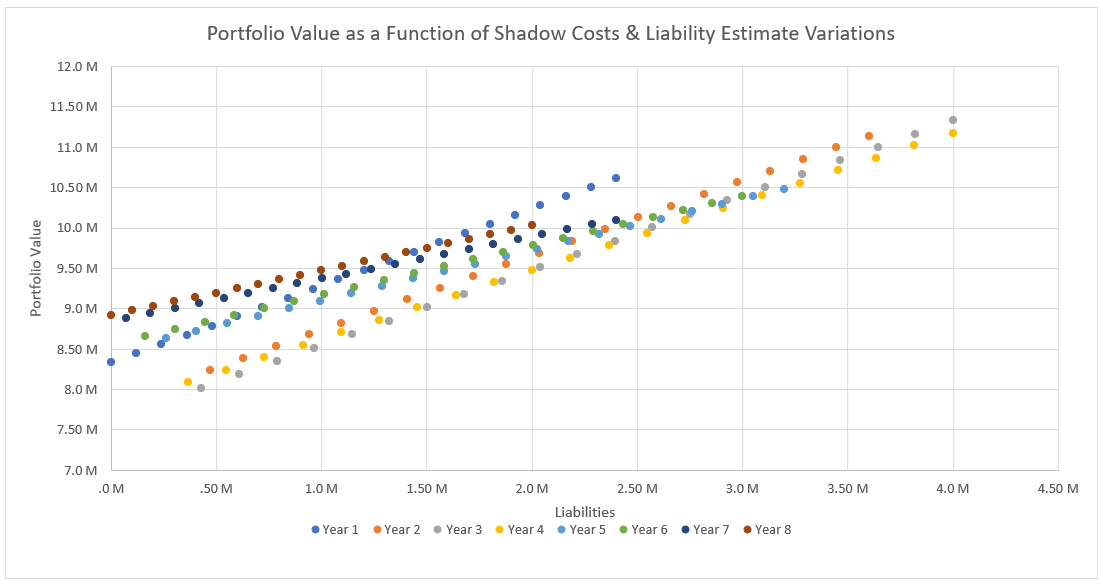

- This plot shows the portfolio as a function of the shadow prices, shown above, and change in an individual liability value, keeping all other liability estimates constant. In this analysis, liabilities were varied from their lower bound, seen in the table above, to twice the estimated amount. It can be seen that the slope of the Year 1 portfolio value is the steepest, which confirms our earlier analsysis. Addtionally, the portfolio values can range from \\$8 million to almost \\$11.5 million. Therefore, if the firm does not have confidence in their liability estimates, it is reasonable to advise the firm to adjust their fixed income investments to reflect the change in liability estimates as seen above. 

## Finding Optimal Portfolio with Treasury Bonds

In [12]:
bond_mat = np.zeros((len(bonds_from_wsj),len(liabilities)+1))

for i in range(len(bonds_from_wsj)):
  bond_mat[i,  int(bonds_from_wsj.iloc[i]['StartTime'])] =  -bonds_from_wsj.iloc[i]['Price']
  bond_mat[i,  int(bonds_from_wsj.iloc[i]['Maturity'])] =  bonds_from_wsj.iloc[i]['Price']+ bonds_from_wsj.iloc[i]['Coupon']

  for j in range( int(bonds_from_wsj.iloc[i]['StartTime']+1) , int(bonds_from_wsj.iloc[i]['Maturity']) ):
    bond_mat[i,j] = bonds_from_wsj.iloc[i]['Coupon']


A = bond_mat.T
bond_df = pd.DataFrame(data = A, columns= ['Bond_%i'%(i) for i in range(1,len(bonds_from_wsj)+1)])
bond_df

,Bond_1,Bond_2,Bond_3,Bond_4,Bond_5,Bond_6,Bond_7,Bond_8,Bond_9,Bond_10,...,Bond_225,Bond_226,Bond_227,Bond_228,Bond_229,Bond_230,Bond_231,Bond_232,Bond_233,Bond_234
0,-100.216,-100.136,-100.146,-100.186,-100.224,-100.282,-100.140,-100.22,-100.234,-101.010,...,-98.246,-99.184,-112.104,-127.006,-109.002,-127.18,-107.102,-101.266,-135.242,-102.234
1,102.716,101.511,101.646,102.061,102.224,102.782,101.265,101.97,102.109,103.385,...,1.125,1.250,3.125,5.250,2.625,5.25,2.375,1.625,6.125,1.750
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,...,1.125,1.250,3.125,5.250,2.625,5.25,2.375,1.625,6.125,1.750
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,...,1.125,1.250,3.125,5.250,2.625,5.25,2.375,1.625,6.125,1.750
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,...,1.125,1.250,3.125,5.250,2.625,5.25,2.375,1.625,6.125,1.750
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,...,1.125,1.250,3.125,5.250,2.625,5.25,2.375,1.625,6.125,1.750
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,...,1.125,1.250,3.125,5.250,2.625,5.25,2.375,1.625,6.125,1.750
7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,...,99.371,100.434,115.229,132.256,2.625,5.25,2.375,1.625,6.125,1.750
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,...,0.000,0.000,0.000,0.000,111.627,132.43,109.477,102.891,141.367,103.984


In [13]:
# set constraint values, equal signs to tell gurobi to match liabilities, and set objective
b = np.array(liabilities['Liability'])
sense = np.array(['=']*len(liabilities))

objective = np.array(bond_df.iloc[0])

wsjMod = gp.Model() # initialize empty model before optimizing
wsjx = wsjMod.addMVar(len(objective)) # tell the model how many variables there are
wsjModCon = wsjMod.addMConstrs(bond_df.iloc[1:len(liabilities)+1], wsjx, sense, b) # add the constraints to the model
wsjMod.setMObjective(None,objective,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model

wsjMod.Params.OutputFlag = 0 #
wsjMod.optimize()

# Total Value of Bonds to be purchased. 
print('Total Value of Bonds Purchased ($) = ', -wsjMod.objVal)

# Total Bond Purchase
pd.DataFrame(wsjx.x, index = ['Bond_%i'%(i) for i in range(1,len(bonds_from_wsj)+1)], columns = ['Quantity'] )

Total Value of Bonds Purchased ($) =  9926378.278402824


,Quantity
Bond_1,0.000000
Bond_2,0.000000
Bond_3,0.000000
Bond_4,0.000000
Bond_5,0.000000
...,...
Bond_230,0.000000
Bond_231,0.000000
Bond_232,0.000000
Bond_233,7073.786669
